In [1]:
import findspark
findspark.init()

In [2]:
import pyspark

In [3]:
from pyspark.sql import SparkSession

In [4]:
appName = "Visualizations"
master = 'local'

# Create Spark session
spark = SparkSession.builder.master(master).appName(appName).getOrCreate()

df = spark.read.option("header",True).csv("/project/input/NJ_Parking.csv")

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

In [6]:
df.select('Summons Number','Plate ID',
'Registration State',
'Plate Type',
'Issue Date',
'Violation Code',
'Vehicle Body Type').describe().toPandas()

,summary,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type
0,count,878677,878676,878677,878677,878677,878677,872518
1,mean,6.744945115569269E9,Infinity,None,None,None,32.315087341537335,3.739130434782609
2,stddev,2.022111483621511E9,NaN,None,None,None,18.96446679869914,0.6887004431501819
3,min,1002891188,0%67^N,NJ,PAS,01/01/2013,0,2 D
4,max,8006050284,ZZZ99R,NJ,PAS,12/31/2013,99,Z


In [7]:
df1=df.toPandas()

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

In [9]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [10]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [11]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [12]:
df1.head(5)

,_c0,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,...,Hydrant Violation,Double Parking Violation,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA
0,5,1283294217,T60DAR,NJ,PAS,08/11/2013,14,P-U,DODGE,P,...,None,None,None,None,None,None,None,None,None,None
1,7,1283983620,XZ764G,NJ,PAS,08/07/2013,24,DELV,FORD,X,...,None,None,None,None,None,None,None,None,None,None
2,9,1283983667,MCL78B,NJ,PAS,07/18/2013,24,SDN,SUBAR,H,...,None,None,None,None,None,None,None,None,None,None
3,22,1286654920,ZTR66R,NJ,PAS,07/18/2013,50,SDN,N/S,T,...,None,None,None,None,None,None,None,None,None,None
4,47,1291896399,G24BLB,NJ,PAS,07/19/2013,40,SDN,INFIN,P,...,None,None,None,None,None,None,None,None,None,None


<ipython-input-9-0121bf3d9d74>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)
<ipython-input-9-0121bf3d9d74>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)
<ipython-input-9-0121bf3d9d74>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)
<ipython-input-9-0121bf3d9d74>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)
<ipython-input-9-0121bf3d9d74>:1

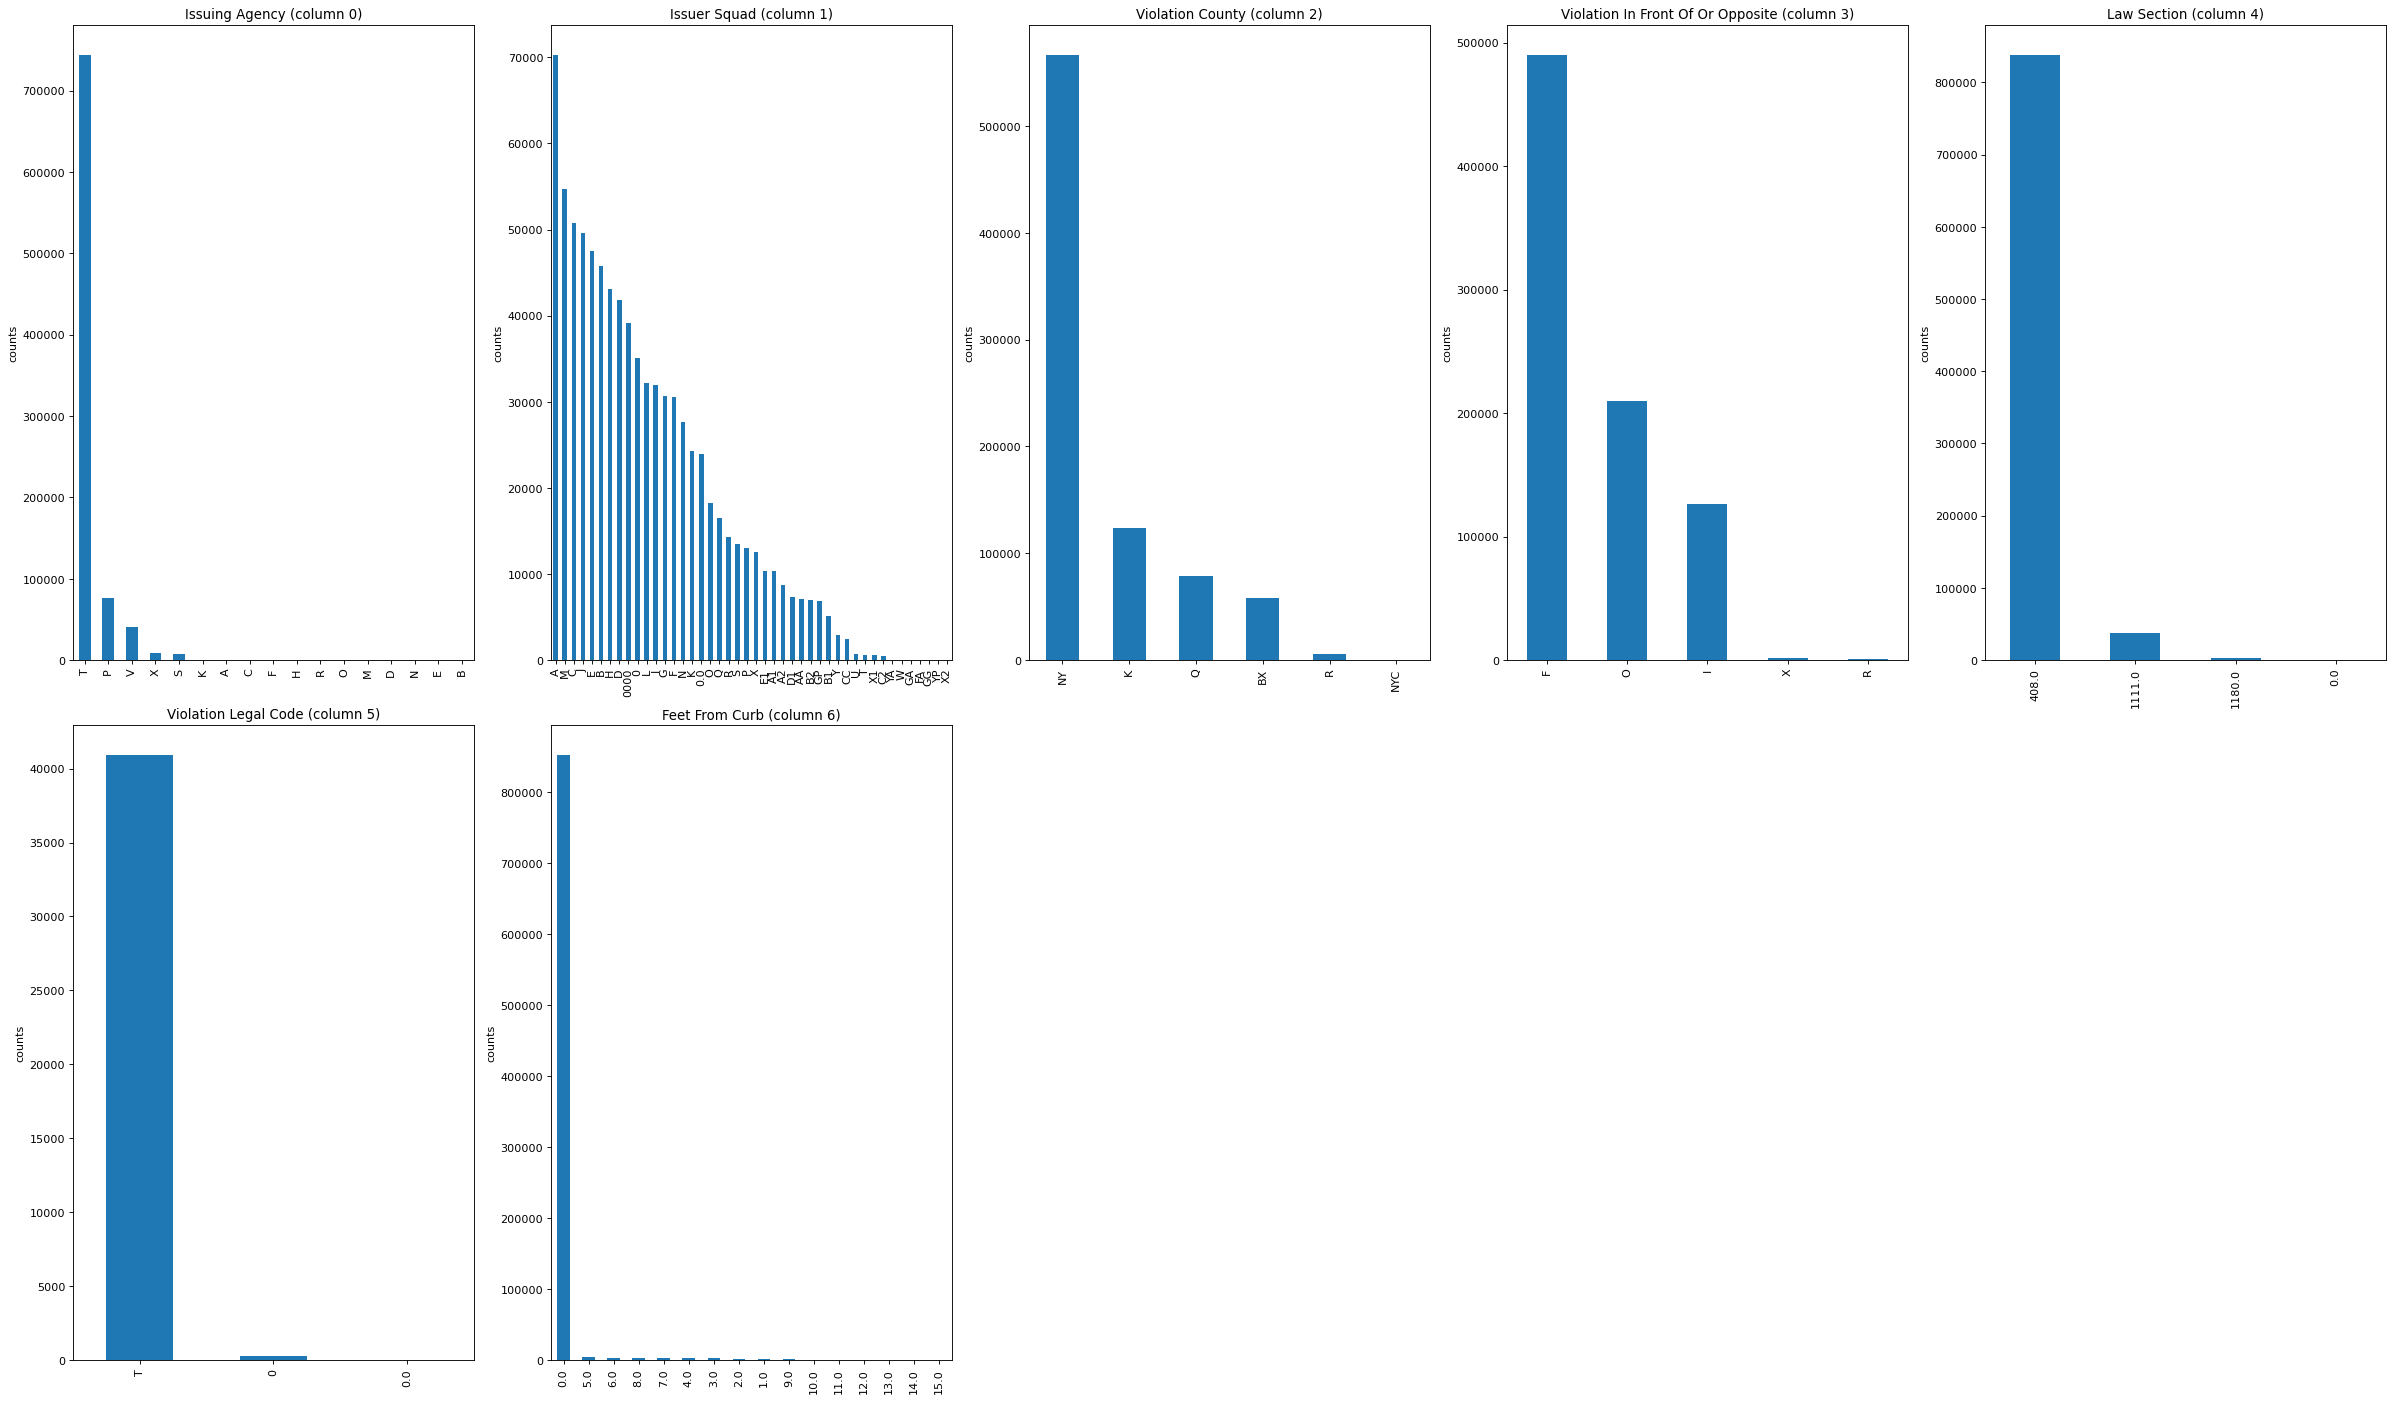

In [13]:
plotPerColumnDistribution(df1, 10, 5)

In [14]:
plotCorrelationMatrix(df1, 8)

AttributeError: 'DataFrame' object has no attribute 'dataframeName'

In [18]:
plotScatterMatrix(df1, 20, 10)

ValueError: Number of columns must be a positive integer, not 0

<Figure size 1440x1440 with 0 Axes>

In [19]:
d = {'Nan Entry': df1.isnull().any(),
    'Unique Entry': df1.nunique(axis = 0)}
pd.DataFrame(data = d, index = df1.columns.values)

,Nan Entry,Unique Entry
_c0,False,878677
Summons Number,False,878677
Plate ID,True,324371
Registration State,False,1
Plate Type,False,1
Issue Date,False,851
Violation Code,False,98
Vehicle Body Type,True,421
Vehicle Make,True,1384
Issuing Agency,False,17


In [20]:
df2 = df1.copy(deep=True)

In [21]:
drop_column = ['Vehicle Color','Plate ID','Issuing Agency','Street Code1','Street Code2','Street Code3','Vehicle Expiration Date',
               'Violation Location','Violation Precinct','Issuer Precinct','Issuer Code','Issuer Command','Issuer Squad','Time First Observed',
              'Violation In Front Of Or Opposite','House Number','Street Name','Intersecting Street','Date First Observed','Law Section',
              'Sub Division','Violation Legal Code','From Hours In Effect','To Hours In Effect','Meter Number','Unregistered Vehicle?','Feet From Curb',
              'Hydrant Violation','Double Parking Violation','Violation Post Code','No Standing or Stopping Violation','Summons Number']
df2.drop(drop_column, axis = 1, inplace = True)


In [22]:
mini = df2.sample(frac = 0.1, replace = False)

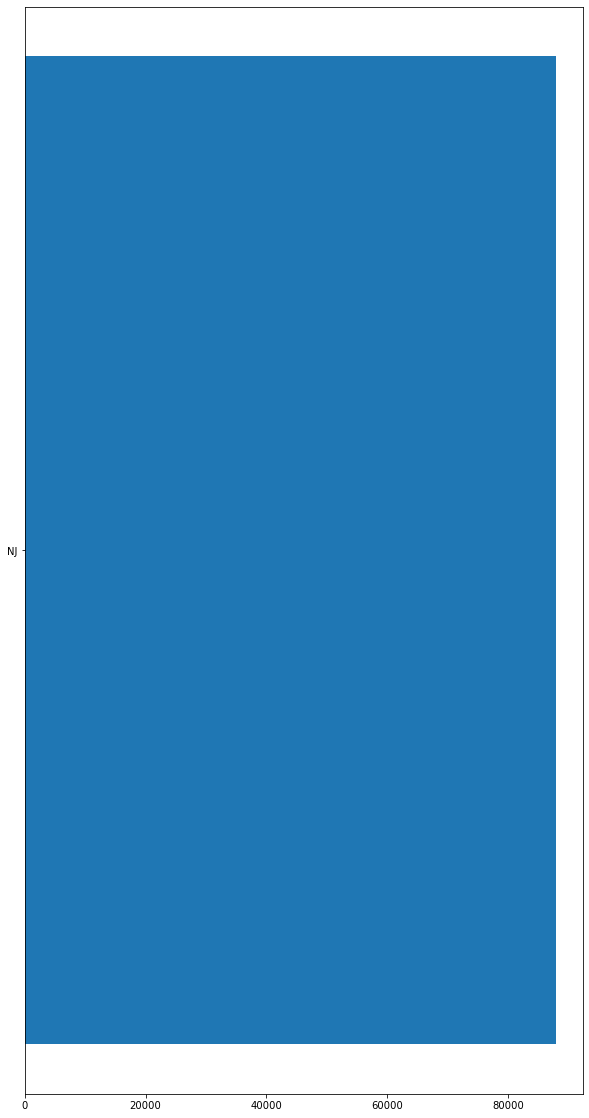

In [23]:
#Run this part for different cities
x_ticks = mini['Registration State'].value_counts().index
heights = mini['Registration State'].value_counts()
y_pos = np.arange(len(x_ticks))
fig = plt.figure(figsize=(10,20)) 
# Create horizontal bars
plt.barh(y_pos, heights)
 
# Create names on the y-axis
plt.yticks(y_pos, x_ticks)
 
# Show graphic
plt.show()

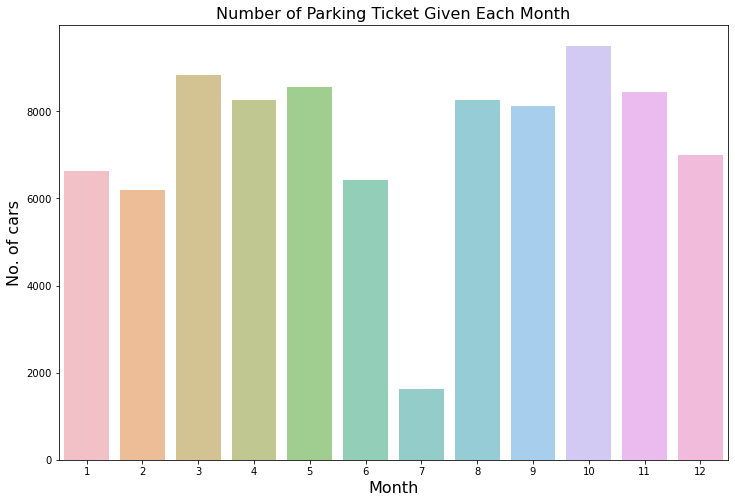

In [24]:
month = []
for time_stamp in pd.to_datetime(mini['Issue Date']):
    month.append(time_stamp.month)
m_count = pd.Series(month).value_counts()

plt.figure(figsize=(12,8))
sns.barplot(y=m_count.values, x=m_count.index, alpha=0.6)
plt.title("Number of Parking Ticket Given Each Month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.ylabel("No. of cars", fontsize=16)
plt.show();

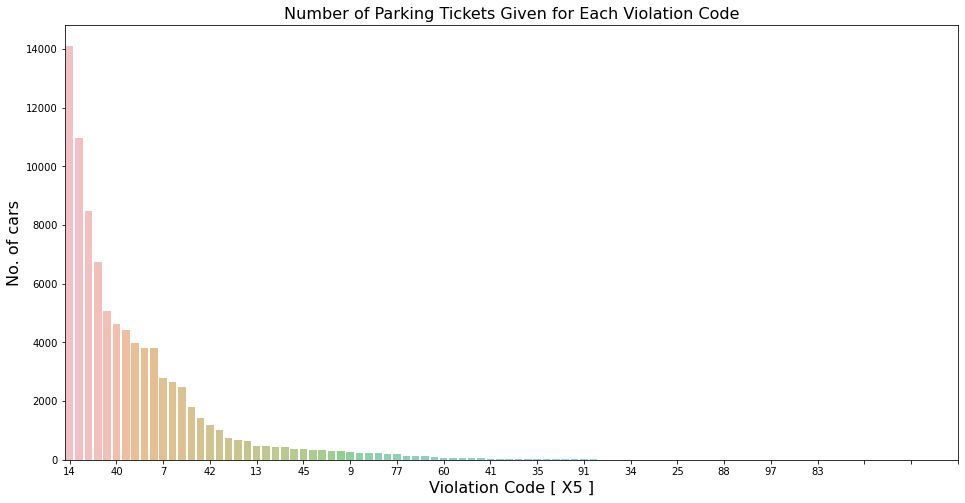

In [25]:
violation_code = mini['Violation Code'].value_counts()

plt.figure(figsize=(16,8))
f = sns.barplot(y=violation_code.values, x=violation_code.index, alpha=0.6)
#plt.xticks(np.arange(0,101, 10.0))
f.set(xticks=np.arange(0,100, 5.0))
plt.title("Number of Parking Tickets Given for Each Violation Code", fontsize=16)
plt.xlabel("Violation Code [ X5 ]", fontsize=16)
plt.ylabel("No. of cars", fontsize=16)
plt.show();

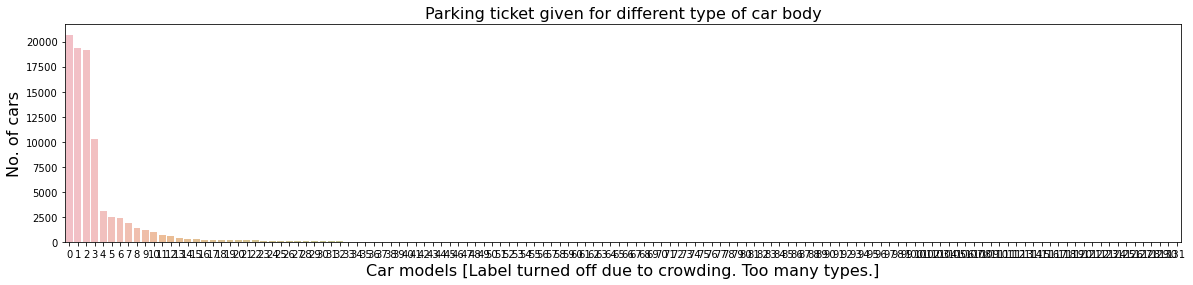

In [26]:
x_ticks = mini['Vehicle Body Type'].value_counts().index
heights = mini['Vehicle Body Type'].value_counts().values
y_pos = np.arange(len(x_ticks))
fig = plt.figure(figsize=(20,4))
f = sns.barplot(y=heights, x=y_pos, orient = 'v', alpha=0.6);
# remove labels
plt.tick_params(labelbottom='off')
plt.ylabel('No. of cars', fontsize=16);
plt.xlabel('Car models [Label turned off due to crowding. Too many types.]', fontsize=16);
plt.title('Parking ticket given for different type of car body', fontsize=16);

Text(0.5, 1.0, 'Parking ticket given for different type of car body')

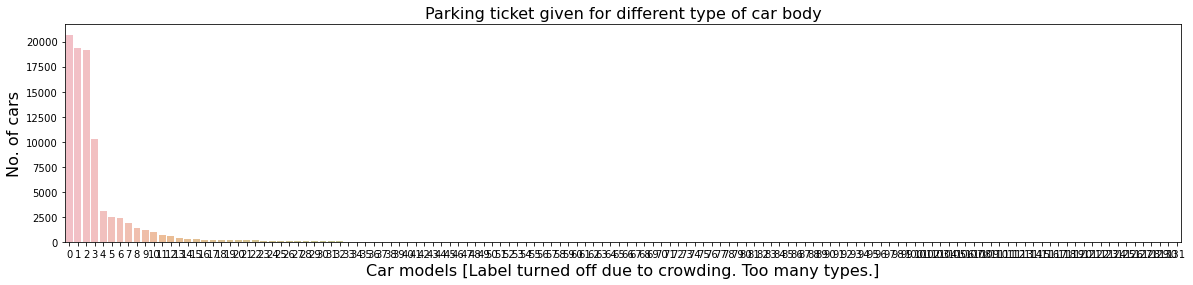

In [27]:
x_ticks = mini['Vehicle Body Type'].value_counts().index
heights = mini['Vehicle Body Type'].value_counts().values
y_pos = np.arange(len(x_ticks))
fig = plt.figure(figsize=(20,4))
f = sns.barplot(y=heights, x=y_pos, orient = 'v', alpha=0.6);
# remove labels
plt.tick_params(labelbottom='off')
plt.ylabel('No. of cars', fontsize=16);
plt.xlabel('Car models [Label turned off due to crowding. Too many types.]', fontsize=16);
plt.title('Parking ticket given for different type of car body', fontsize=16)

In [29]:
mini.set_index('Violation Time', drop=False, inplace=True)
plt.figure(figsize=(16,8))
mini['Violation Time'].groupby(pd.TimeGrouper(freq='60Min')).count().plot(kind='bar');
plt.tick_params(labelbottom='on')
plt.ylabel('No. of cars', fontsize=16);
plt.xlabel('Day Time', fontsize=16);
plt.title('Parking ticket given at different time of the day', fontsize=16);

AttributeError: module 'pandas' has no attribute 'TimeGrouper'

<Figure size 1152x576 with 0 Axes>

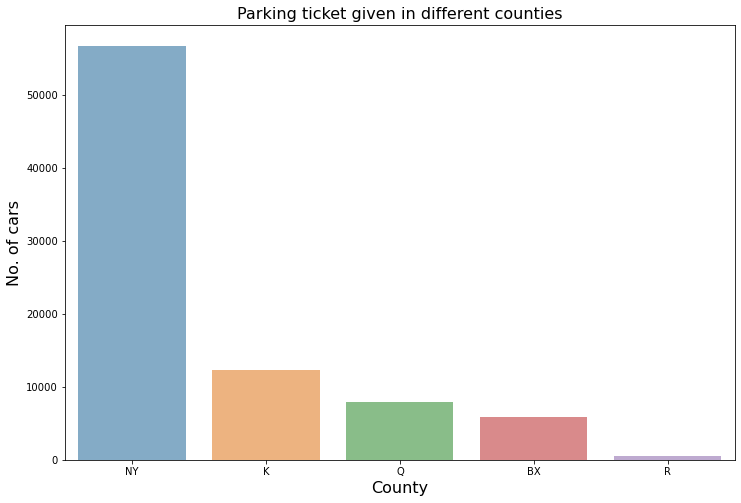

In [30]:
violation_county = mini['Violation County'].value_counts()

plt.figure(figsize=(12,8))
f = sns.barplot(y=violation_county.values, x=violation_county.index, alpha=0.6)
# remove labels
plt.tick_params(labelbottom='on')
plt.ylabel('No. of cars', fontsize=16);
plt.xlabel('County', fontsize=16);
plt.title('Parking ticket given in different counties', fontsize=16);

In [ ]:
plt.figure(figsize=(13,6))
x=df1['Summons Number']
y=df1['Registration State']

plt.bar(y,x, color = 'b', width = 0.75)
plt.xticks( rotation=90)

plt.title("Number of Parking Tickets Given for Each State registered Car", fontsize=16)
plt.xlabel("Registration State", fontsize=18)
plt.ylabel("No. of cars", fontsize=18)
plt.show()

In [ ]:
import matplotlib.patches as mpatches